In [30]:
from src.utils.bq import BQ
from google.cloud import bigquery

# Initialize BigQuery connection
bq = BQ()

# Get transaction data
TRANSACTION_QUERY = """
DECLARE cutoff_date DATE DEFAULT DATE '2025-06-01';     -- analysis cutoff
DECLARE churn_gap   INT64 DEFAULT 45;                  -- days with no txn = churn

WITH base AS (
  SELECT
    customer_id,
    DATE(transaction_completed_datetime) AS txn_date
  FROM `mpb-data-science-dev-ab-602d.dsci_daw.STV`
  WHERE transaction_state = 'COMPLETED'
    AND transaction_completed_datetime >= '2020-01-01'
),

customer_spans AS (
  SELECT
    customer_id,
    MIN(txn_date) AS first_txn_date,
    MAX(txn_date) AS last_txn_date
  FROM base
  WHERE txn_date < cutoff_date
  GROUP BY customer_id
),

labels AS (
  SELECT
    customer_id as id,
    -- define duration T
    DATE_DIFF(
      LEAST(cutoff_date, DATE_ADD(last_txn_date, INTERVAL churn_gap DAY)),
      first_txn_date,
      DAY
    ) AS T,
    
    -- define event E (1=churned before cutoff, 0=censored)
    CASE
      WHEN DATE_ADD(last_txn_date, INTERVAL churn_gap DAY) < cutoff_date
        THEN 1  -- churn happened
      ELSE 0    -- still alive / censored
    END AS E,
    DATE_TRUNC(first_txn_date, YEAR) AS first_year
  FROM customer_spans
)

SELECT * FROM labels;
"""

job_config = bigquery.QueryJobConfig()
dtypes = {"id": "int32", "T": "int32", "E": "int16"}

transactions = bq.to_dataframe(TRANSACTION_QUERY, job_config=job_config, dtypes=dtypes)

/Users/anthonybeech/python/dsci/ltv/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [31]:
transactions.head()

,id,T,E,first_year
0,1176560,1446,1,2020-01-01
1,996409,45,1,2020-01-01
2,816720,1941,0,2020-01-01
3,817127,1389,1,2020-01-01
4,1582865,1717,1,2020-01-01


In [32]:
T = transactions["T"]
E = transactions["E"]

In [33]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)  # or, more succinctly, kmf.fit(T, E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 296225 total observations, 14550 right-censored observations>

<Axes: xlabel='timeline'>

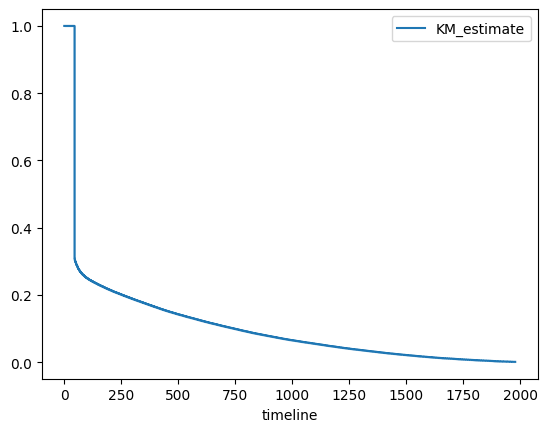

In [34]:
kmf.survival_function_
kmf.cumulative_density_
kmf.plot_survival_function()

In [15]:
from lifelines.utils import median_survival_times

median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)

/Users/anthonybeech/python/dsci/ltv/.venv/lib/python3.12/site-packages/lifelines/fitters/__init__.py:1024: StatisticalWarning: The diagonal of the variance_matrix_ has negative values or NaNs. This could be a problem with GeneralizedGammaFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too. Perform plots of the cumulative hazard to help understand the latter's bias.

To fix this, try specifying an `initial_point` kwarg in `fit`.

  warnings.warn(warning_text, exceptions.StatisticalWarning)
/Users/anthonybeech/python/dsci/ltv/.venv/lib/python3.12/site-packages/lifelines/fitters/__init__.py:1011: ApproximationWarning: 
The Hessian for SplineFitter's fit was not invertible. We will instead approximate it using the pseudo-inverse.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too. Perform plots of the cumulative hazard to help understand the latter's bias.

  war

<Axes: >

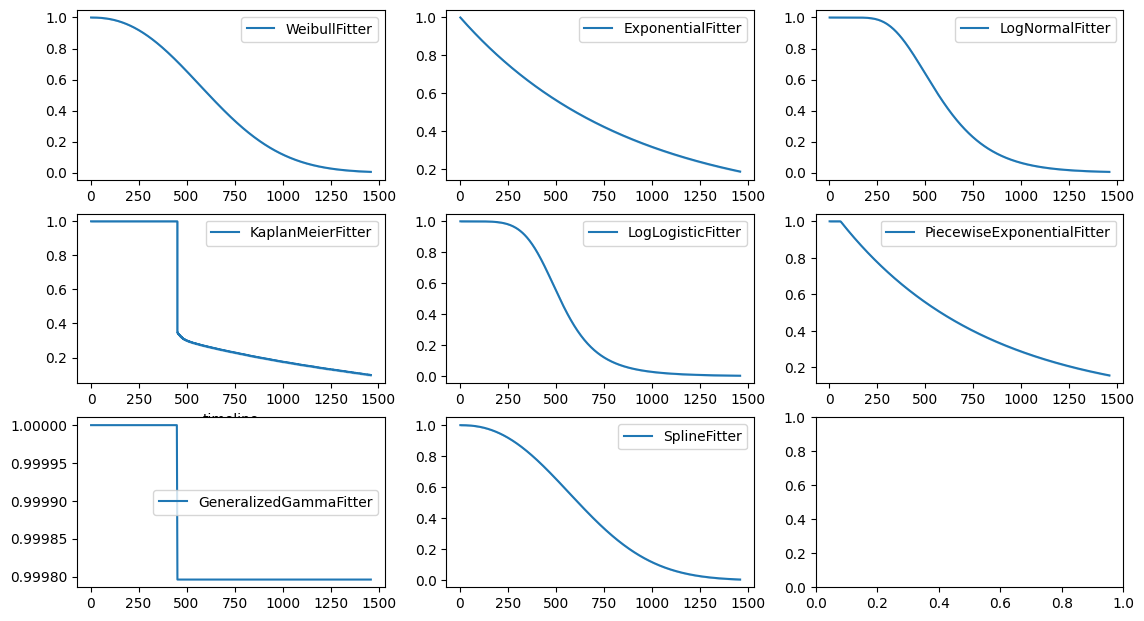

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from lifelines import (
    KaplanMeierFitter,
    WeibullFitter,
    ExponentialFitter,
    LogNormalFitter,
    LogLogisticFitter,
    PiecewiseExponentialFitter,
    GeneralizedGammaFitter,
    SplineFitter,
)

fig, axes = plt.subplots(3, 3, figsize=(13.5, 7.5))

kmf = KaplanMeierFitter().fit(T, E, label="KaplanMeierFitter")
wbf = WeibullFitter().fit(T, E, label="WeibullFitter")
exf = ExponentialFitter().fit(T, E, label="ExponentialFitter")
lnf = LogNormalFitter().fit(T, E, label="LogNormalFitter")
llf = LogLogisticFitter().fit(T, E, label="LogLogisticFitter")
pwf = PiecewiseExponentialFitter([40, 60]).fit(T, E, label="PiecewiseExponentialFitter")
ggf = GeneralizedGammaFitter().fit(T, E, label="GeneralizedGammaFitter")
sf = SplineFitter(np.percentile(T.loc[E.astype(bool)], [0, 50, 100])).fit(
    T, E, label="SplineFitter"
)

wbf.plot_survival_function(ax=axes[0][0])
exf.plot_survival_function(ax=axes[0][1])
lnf.plot_survival_function(ax=axes[0][2])
kmf.plot_survival_function(ax=axes[1][0])
llf.plot_survival_function(ax=axes[1][1])
pwf.plot_survival_function(ax=axes[1][2])
ggf.plot_survival_function(ax=axes[2][0])
sf.plot_survival_function(ax=axes[2][1])

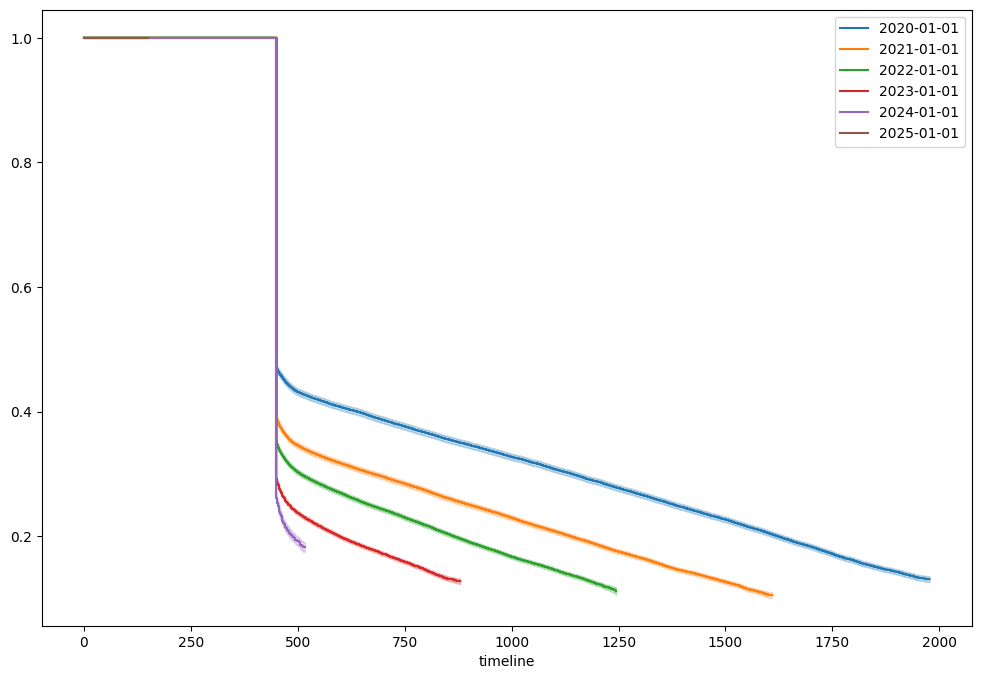

In [ ]:
plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
kmf = KaplanMeierFitter()

for name, df in transactions.groupby("first_year"):
    kmf.fit(df["T"], df["E"], label=str(name))
    kmf.plot_survival_function(ax=ax)

### As a flow

In [41]:
# Complete Customer Survival Analysis - All in One Cell
import pandas as pd
import numpy as np
from lifelines import WeibullFitter
from src.utils.bq import BQ
from google.cloud import bigquery

# Initialize BigQuery connection
bq = BQ()

# Get survival data for each customer
SURVIVAL_QUERY = """
DECLARE cutoff_date DATE DEFAULT DATE '2025-06-01';
DECLARE churn_gap   INT64 DEFAULT 45;

WITH base AS (
  SELECT
    customer_id,
    DATE(transaction_completed_datetime) AS txn_date,
    coalesce(inbound_payment_value - outbound_payment_value, 0) as value
  FROM `mpb-data-science-dev-ab-602d.dsci_daw.STV`
  WHERE transaction_state = 'COMPLETED'
    AND transaction_completed_datetime >= '2020-01-01'
),

customer_metrics AS (
  SELECT
    customer_id as id,
    MIN(txn_date) AS first_txn_date,
    MAX(txn_date) AS last_txn_date,
    COUNT(*) AS frequency,
    DATE_DIFF(MAX(txn_date), MIN(txn_date), DAY) / 7.0 AS recency_weeks,
    AVG(value) AS monetary_value,
    DATE_DIFF(cutoff_date, MIN(txn_date), DAY) / 7.0 AS T_weeks
  FROM base
  WHERE txn_date < cutoff_date
  GROUP BY customer_id
),

survival_data AS (
  SELECT
    id,
    GREATEST(frequency - 1, 0) as frequency,  -- Frequency is repeat purchases
    recency_weeks as recency,
    T_weeks as T,
    monetary_value,
    -- Survival analysis variables
    DATE_DIFF(
      LEAST(cutoff_date, DATE_ADD(last_txn_date, INTERVAL churn_gap DAY)),
      first_txn_date,
      DAY
    ) AS survival_T,
    
    CASE
      WHEN DATE_ADD(last_txn_date, INTERVAL churn_gap DAY) < cutoff_date
        THEN 1  -- churn happened
      ELSE 0    -- still alive / censored
    END AS E
    
  FROM customer_metrics
)

SELECT * FROM survival_data;
"""

survival_df = bq.to_dataframe(SURVIVAL_QUERY, job_config=job_config)

# Fit Weibull survival model
wbf = WeibullFitter()
wbf.fit(survival_df["survival_T"], survival_df["E"])

# Create customer analysis dataframe matching lifetimes structure
customer_analysis = survival_df[
    ["id", "frequency", "recency", "T", "monetary_value"]
].copy()
customer_analysis.set_index("id", inplace=True)

# Probability alive using survival function
p_alive_values = []
for t in survival_df["survival_T"]:
    p_alive_values.append(wbf.survival_function_at_times(t).values[0])

customer_analysis["p_alive"] = p_alive_values

# Expected purchases next 5 years - simplified approach
# Use survival probability as proxy for activity level
median_survival = wbf.median_survival_time_
customer_analysis["expected_purchases_5y"] = (
    customer_analysis["p_alive"]
    * (customer_analysis["frequency"] / customer_analysis["T"])
    * 260  # 5 years in weeks
).fillna(0)

# Average order value - use historical monetary value
customer_analysis["avg_order_value"] = customer_analysis["monetary_value"]

# CLV for next 5 years
customer_analysis["clv_5y"] = (
    customer_analysis["expected_purchases_5y"] * customer_analysis["avg_order_value"]
).fillna(0)

# Additional useful metrics to match lifetimes
customer_analysis["customer_age_weeks"] = customer_analysis["T"]
customer_analysis["days_since_last_purchase"] = (
    customer_analysis["recency"] * 7
)  # Convert weeks to days
customer_analysis["purchase_rate_per_week"] = (
    customer_analysis["frequency"] / customer_analysis["T"]
)
customer_analysis["purchase_rate_per_week"] = customer_analysis[
    "purchase_rate_per_week"
].fillna(0)

# Customer segments based on CLV
clv_finite = customer_analysis["clv_5y"].replace([np.inf, -np.inf], np.nan)
valid_clv_mask = clv_finite.notna() & (clv_finite > 0)

customer_analysis["clv_quartile"] = "No CLV"
if valid_clv_mask.sum() > 0:
    quartiles = pd.qcut(
        clv_finite[valid_clv_mask],
        4,
        labels=["Low", "Medium", "High", "Premium"],
        duplicates="drop",
    )
    customer_analysis.loc[valid_clv_mask, "clv_quartile"] = quartiles


# Customer status based on probability alive
def get_customer_status(p_alive):
    if p_alive <= 0.3:
        return "Lost"
    elif p_alive < 0.6:
        return "Lapsing"
    else:
        return "Active"


customer_analysis["status"] = customer_analysis["p_alive"].apply(get_customer_status)

print("Customer Survival Analysis Summary:")
print(f"Total customers: {len(customer_analysis):,}")
print(f"Customers with valid CLV: {valid_clv_mask.sum():,}")
print("Customer Status Distribution:")
print(customer_analysis["status"].value_counts())
print("\nCLV Quartile Distribution:")
print(customer_analysis["clv_quartile"].value_counts())
print(f"\nAverage CLV (5y): ${customer_analysis['clv_5y'].mean():.2f}")
print(f"Total CLV (5y): ${customer_analysis['clv_5y'].sum():,}")

customer_analysis.head(10)

/Users/anthonybeech/python/dsci/ltv/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Customer Survival Analysis Summary:
Total customers: 296,225
Customers with valid CLV: 92,379
Customer Status Distribution:
status
Active     217433
Lost        60271
Lapsing     18521
Name: count, dtype: int64

CLV Quartile Distribution:
clv_quartile
No CLV     203846
Medium      23095
Premium     23095
Low         23095
High        23094
Name: count, dtype: int64

Average CLV (5y): $514.77
Total CLV (5y): $152,487,978.58461654


,frequency,recency,T,monetary_value,p_alive,expected_purchases_5y,avg_order_value,clv_5y,customer_age_weeks,days_since_last_purchase,purchase_rate_per_week,clv_quartile,status
id,,,,,,,,,,,,,
1749997,10,211.000000,213.571429,1031.272727,0.006298,0.076675,1031.272727,79.072603,213.571429,1477.0,0.046823,Medium,Lost
1527349,9,106.571429,155.285714,1238.110000,0.041600,0.626865,1238.110000,776.127791,155.285714,746.0,0.057958,High,Lost
2624903,31,105.714286,110.428571,1204.543750,0.043870,3.201996,1204.543750,3856.944294,110.428571,740.0,0.280724,Premium,Lost
2415177,42,113.571429,115.285714,1305.608837,0.039691,3.759597,1305.608837,4908.562947,115.285714,795.0,0.364312,Premium,Lost
2411385,48,4.571429,76.857143,183.017347,0.561200,91.127142,183.017347,16677.847821,76.857143,32.0,0.624535,Premium,Lapsing
1345906,14,128.428571,185.857143,765.333333,0.026806,0.524985,765.333333,401.788324,185.857143,899.0,0.075327,High,Lost
1074093,7,232.571429,259.428571,5119.125000,0.004077,0.028599,5119.125000,146.400414,259.428571,1628.0,0.026982,Medium,Lost
2083039,7,30.000000,184.714286,1447.500000,0.249538,2.458709,1447.500000,3558.981067,184.714286,210.0,0.037896,Premium,Lost
1354292,7,214.142857,229.857143,2121.000000,0.005580,0.044183,2121.000000,93.711736,229.857143,1499.0,0.030454,Medium,Lost
